<a href="https://colab.research.google.com/github/mdpw/msc-ai-cw/blob/main/cnn_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
file_path = "https://raw.githubusercontent.com/mdpw/msc-ai-cw/main/dataset/modified_cinnamon_quality_dataset.csv"
df = pd.read_csv(file_path)

# --- 1. Data Preparation ---
df = df.drop(columns=['Sample_ID'])
X = df.drop(columns=['Quality_Label'])
y = df['Quality_Label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

Epoch 1/30 | Train Loss: 0.8962, Train Acc: 0.6402 | Val Loss: 0.6669, Val Acc: 0.6667
Epoch 2/30 | Train Loss: 0.5463, Train Acc: 0.7434 | Val Loss: 0.4094, Val Acc: 0.8175
Epoch 3/30 | Train Loss: 0.3538, Train Acc: 0.8796 | Val Loss: 0.2513, Val Acc: 0.9405
Epoch 4/30 | Train Loss: 0.2084, Train Acc: 0.9696 | Val Loss: 0.1282, Val Acc: 0.9722
Epoch 5/30 | Train Loss: 0.1166, Train Acc: 0.9934 | Val Loss: 0.0630, Val Acc: 1.0000
Epoch 6/30 | Train Loss: 0.0615, Train Acc: 0.9934 | Val Loss: 0.0337, Val Acc: 1.0000
Epoch 7/30 | Train Loss: 0.0381, Train Acc: 0.9947 | Val Loss: 0.0185, Val Acc: 1.0000
Epoch 8/30 | Train Loss: 0.0300, Train Acc: 0.9987 | Val Loss: 0.0176, Val Acc: 1.0000
Epoch 9/30 | Train Loss: 0.0241, Train Acc: 0.9947 | Val Loss: 0.0138, Val Acc: 1.0000
Epoch 10/30 | Train Loss: 0.0150, Train Acc: 1.0000 | Val Loss: 0.0086, Val Acc: 1.0000
Epoch 11/30 | Train Loss: 0.0135, Train Acc: 1.0000 | Val Loss: 0.0067, Val Acc: 1.0000
Epoch 12/30 | Train Loss: 0.0095, Train A

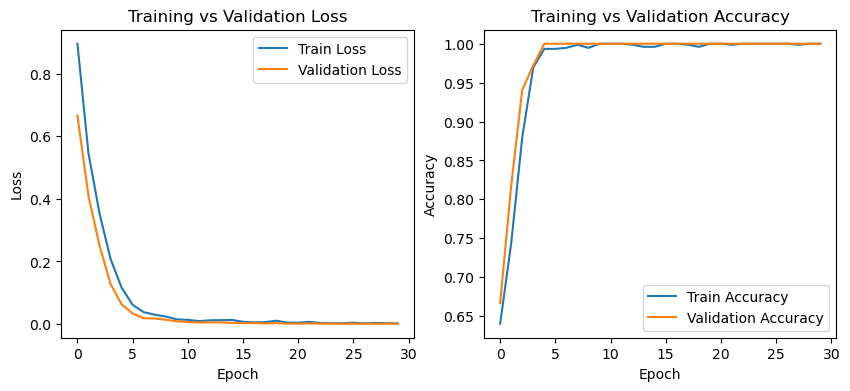

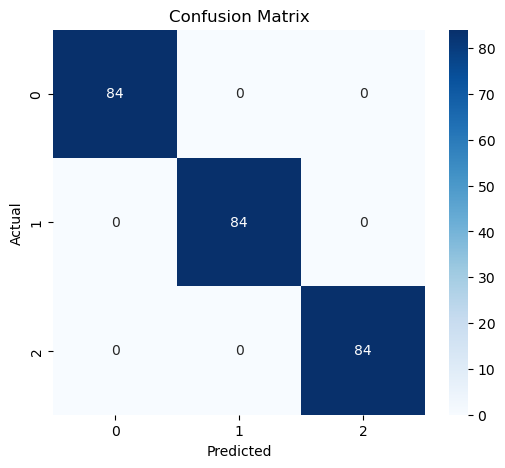

Classification Report:

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        84
         Low       1.00      1.00      1.00        84
      Medium       1.00      1.00      1.00        84

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252

Overlap between train and test (data leakage check): False


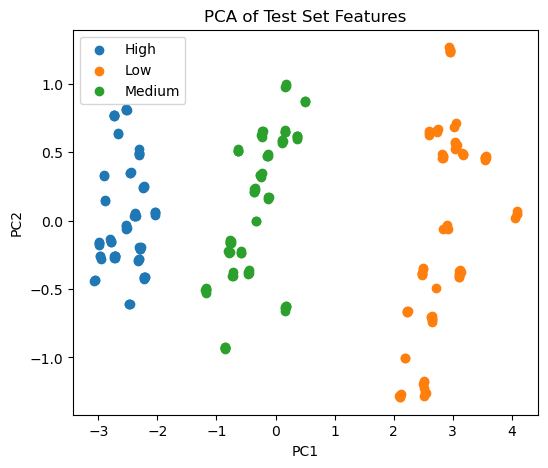

In [16]:
# --- 2. ANN Model with Dropout ---
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = len(le.classes_)

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = ANN()

# --- 3. Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# --- 4. Training loop with Early Stopping and metric storage ---
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

# --- 5. Plot Loss & Accuracy curves ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# --- 6. Test Evaluation ---
y_test_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.tolist())

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# Data leakage check
train_rows = X_train_tensor.numpy()
test_rows = X_test_tensor.numpy()
overlap = np.any(np.all(np.isin(test_rows[:, None], train_rows), axis=2))
print("Overlap between train and test (data leakage check):", overlap)

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(6,5))
for label in np.unique(y_test_enc):
    plt.scatter(X_pca[y_test_enc==label,0], X_pca[y_test_enc==label,1], label=le.classes_[label])
plt.legend()
plt.title("PCA of Test Set Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
# Recreate the model architecture
model = ANN()  # Same as used during training

# Load the best saved weights
model.load_state_dict(torch.load("best_model.pth"))

# Set to evaluation mode
model.eval()

ANN(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

def predict_quality(
    model_class,            # Your ANN class
    model_path,             # Path to saved model weights, e.g., "best_model.pth"
    scaler,                 # Fitted StandardScaler used during training
    label_encoder,          # Fitted LabelEncoder used during training
    new_data: pd.DataFrame  # New samples with same features as training data
):
    """
    Predicts class labels and probabilities for new samples using a trained ANN.
    
    Returns:
        predicted_labels: List of predicted class names
        probabilities: Tensor of shape (n_samples, n_classes)
    """
    # 1. Preprocess new data
    new_data_scaled = scaler.transform(new_data)
    new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)
    
    # 2. Load model
    model = model_class()  # Initialize the architecture
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode
    
    # 3. Make predictions
    with torch.no_grad():
        outputs = model(new_data_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Class probabilities
        _, predicted_indices = torch.max(outputs, 1)   # Predicted class indices
    
    # 4. Convert indices to labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices.numpy())
    
    return predicted_labels, probabilities


In [21]:
# Example usage
new_samples = pd.DataFrame([
    {"Moisture": 12.19, "Ash": 7.356, "Volatile_Oil": 0.626, "Acid_Insoluble_Ash": 0.581, "Chromium": 0.002, "Coumarin": 0.015},    
])

predicted_labels, probabilities = predict_quality(
    model_class=ANN,
    model_path="best_model.pth",
    scaler=scaler,
    label_encoder=le,
    new_data=new_samples
)

print("Predicted labels:", predicted_labels)
print("Predicted probabilities:\n", probabilities)


Predicted labels: ['Low']
Predicted probabilities:
 tensor([[4.3099e-08, 9.9999e-01, 1.3619e-05]])
